In [117]:
import pandas as pd

df = pd.read_csv(r'C:\Users\Acer\DataSets\product_demand.csv')

In [118]:
df['Value'] = df['Value'].astype(int)
df['DATE'] = pd.to_datetime(df['DATE'])
df.set_index('DATE', inplace=True)

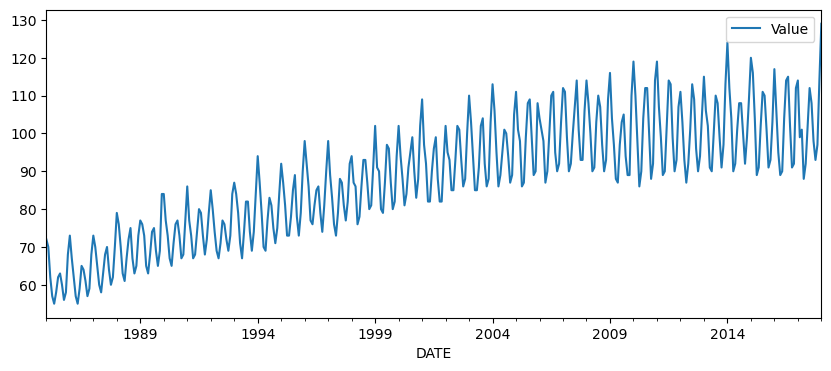

In [119]:
import matplotlib.pyplot as plt
df.plot(figsize=(10,4))
plt.show()

In [63]:
# Train/Test Split
train = df[:int(len(df)*0.85)]
test = df[int(len(df)*0.85):]

In [64]:
from statsmodels.tsa.stattools import adfuller

# Run Dicky-Fuller test
result = adfuller(train)

# Print test statistic
print('The test stastics:', result[0])

# Print p-value
print("The p-value:",result[1])

The test stastics: -2.137928647810411
The p-value: 0.22953922646057828


In [ ]:
# Since p-value > 0.05, we can conclude the data is not stationary, hence we have to difference it

In [65]:
# Trying ADFuller on differenced data
from statsmodels.tsa.stattools import adfuller

# Run Dicky-Fuller test
result = adfuller(train.diff().dropna())

# Print test statistic
print('The test stastics:', result[0])

# Print p-value
print("The p-value:",result[1])

The test stastics: -6.375624895719729
The p-value: 2.2876821562346976e-08


In [ ]:
# Now we know that data is stationary, after applying one order differencing d=1

<AxesSubplot:xlabel='DATE'>

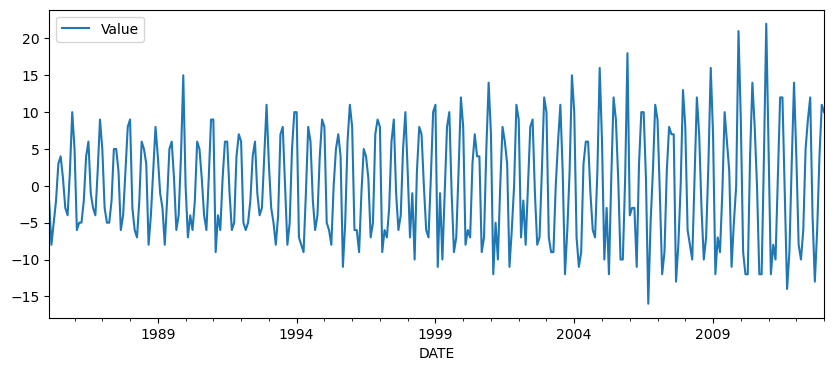

In [120]:
# Plotting the stationary data
train.diff().dropna().plot(figsize=(10,4))

C:\Users\Acer\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


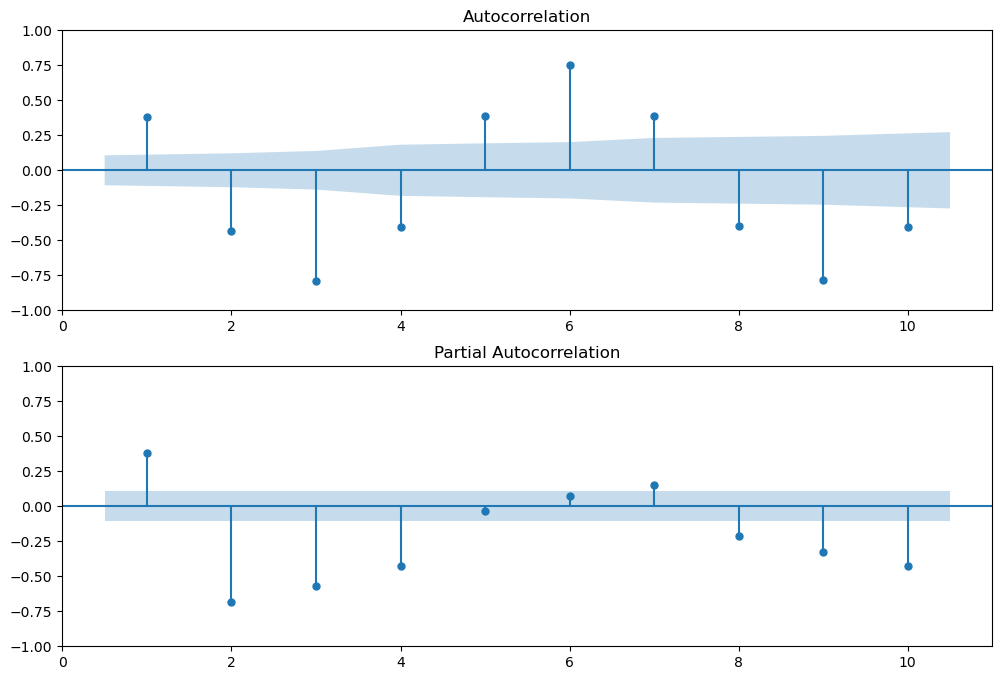

In [121]:
# Checking p and q order with ACF (Autocorrelation Function) and PACF (Partial Autocorrelation Function)
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Create figure
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12,8))

# Plot the ACF of savings on ax1
plot_acf(train.diff().dropna(), lags=10, zero=False, ax=ax1)

# Plot the PACF of savings on ax2
plot_pacf(train.diff().dropna(), lags=10, zero=False, ax=ax2)

plt.show()

In [ ]:
# There are several autocorrelations that are significantly non-zero. Therefore, the time series is non-random.
# Looks like there's a significant pattern spike on ACF, which we will look closer later
# The ACF and PACF plots don't follow a certain pattern together, hence it will be hard to indetify the model orders (p,q) using these plots.
# Some usual patterns for AR or MA models:
'''
1 - If the PACF plot has a significant spike at lag p, but not beyond & the ACF plot decays more
gradually, it suggests an ARIMA(p,d,0) model.

2 - If the ACF plot has a significant spike at lag q, but not beyond & the PACF plot decays more gradually,
it suggests an ARIMA(0,d,q) model'''

# Since they do not follow a certain pattern together, it can be an indicative of an ARIMA(p,1,q) model, rather than just AR(p,1,0) or MA(0,1,q).

In [122]:
# Let's use AIC and BIC to help us determine the order, since we couldn't get it from ACF and PACF

import statsmodels.api as sm
order_aic_bic =[]

# Loop over p values from 0-5
for p in range(5):
    # Loop over q values from 0-5
    for q in range(5):

        try:
            # create and fit ARMA(p,q) model
            model = sm.tsa.statespace.SARIMAX(train, order=(p, 1, q))
            results = model.fit()

            # Print order and results
            order_aic_bic.append((p, q, results.aic, results.bic))
        except:
            print(p, q, None, None)

# Make DataFrame of model order and AIC/BIC scores
order_df = pd.DataFrame(order_aic_bic, columns=['p', 'q', 'aic','bic'])

C:\Users\Acer\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Acer\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Acer\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Acer\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Acer\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self.

C:\Users\Acer\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Acer\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Acer\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Acer\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Acer\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS wi

4 4 None None


In [16]:
order_df.sort_values(by='aic', ascending=True).head()

,p,q,aic,bic
14,2,4,1715.500082,1742.219860
19,3,4,1720.447763,1750.984653
24,4,4,1725.486600,1759.840601
13,2,3,1741.830119,1764.732786
22,4,2,1742.158527,1768.878305


In [17]:
order_df.sort_values(by='bic', ascending=True).head()

,p,q,aic,bic
14,2,4,1715.500082,1742.219860
19,3,4,1720.447763,1750.984653
24,4,4,1725.486600,1759.840601
12,2,2,1745.346666,1764.432221
13,2,3,1741.830119,1764.732786


C:\Users\Acer\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Acer\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Acer\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


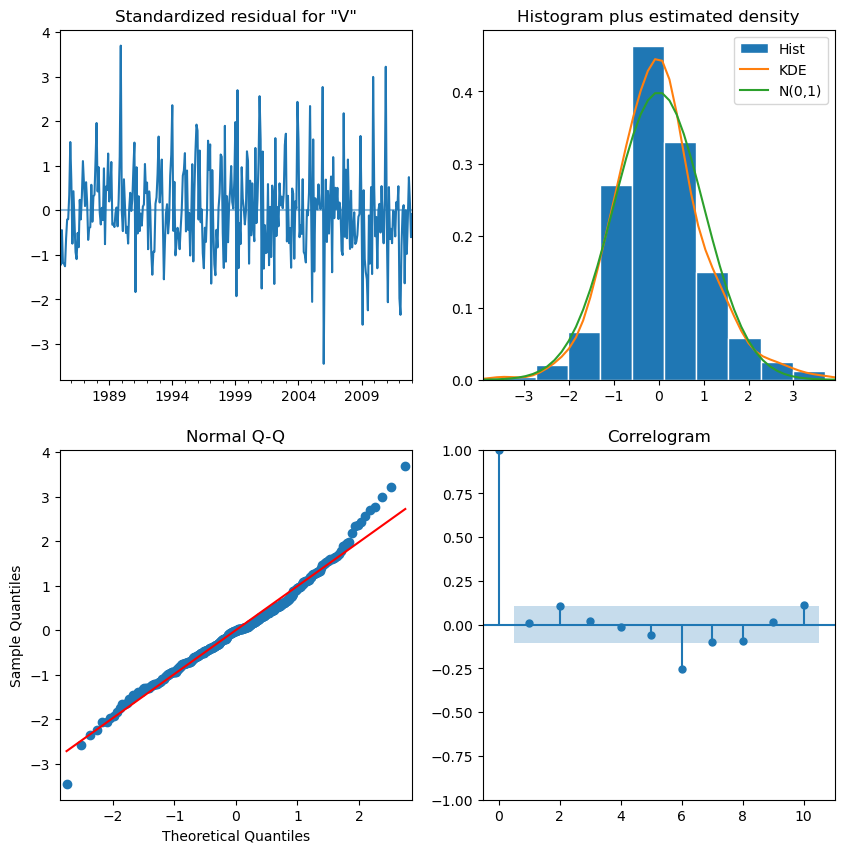

                               SARIMAX Results                                
Dep. Variable:                  Value   No. Observations:                  337
Model:               SARIMAX(2, 1, 4)   Log Likelihood                -846.779
Date:                Sun, 01 Oct 2023   AIC                           1709.557
Time:                        17:01:15   BIC                           1740.094
Sample:                    01-01-1985   HQIC                          1721.730
                         - 01-01-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1154      0.022      5.233      0.000       0.072       0.159
ar.L1          0.9965      0.003    291.786      0.000       0.990       1.003
ar.L2         -0.9979      0.003   -363.555      0.0

In [123]:
# Both aic and bic performed better on order (p,q) = (2,4)
# AIC and BIC shows that 2,4 is our best model

# Create and fit model
model = sm.tsa.statespace.SARIMAX(train, order=(2,1,4), trend='c')
results = model.fit()

# Create the 4 diagostics plots
results.plot_diagnostics(figsize=(10,10))
plt.show()

# Print summary
print(results.summary())

In [ ]:
# From correlogram: The lower lags barely shows any significant spikes, which can be an indicative that residuals are close to white noise
# Residuals must look like white noise to have a good prediction

In [ ]:
# Prob(Q) is the p-value of the null hypothesis that states the residuals have no correlation structure

# Prob(JB) is the p-value of the null hypothesis that states the residuals are Gaussian normally distributed

# So, we can conclude that we fail to reject null hypothesis if p-value > alpha, in which alpha = 0.05

# Hence, from Prob(Q), residuals have no correlation structure, which is a good thing for the model

# Also, from Prob(JB), we can conclude that residuals do not follow a Gaussian normal distribution

# From the correlogram, we can see that there's a significant spike on lag 6, this can be an indicative that the model didn't capture all patterns (maybe the seasonality)

In [124]:
pred = results.predict(start=len(train), end=len(df)-1)

In [125]:
pred.shape

(60,)

In [126]:
test.shape

(60, 1)

In [127]:
df['forecast'] = [None]*len(train) + list(pred)

<AxesSubplot:xlabel='DATE'>

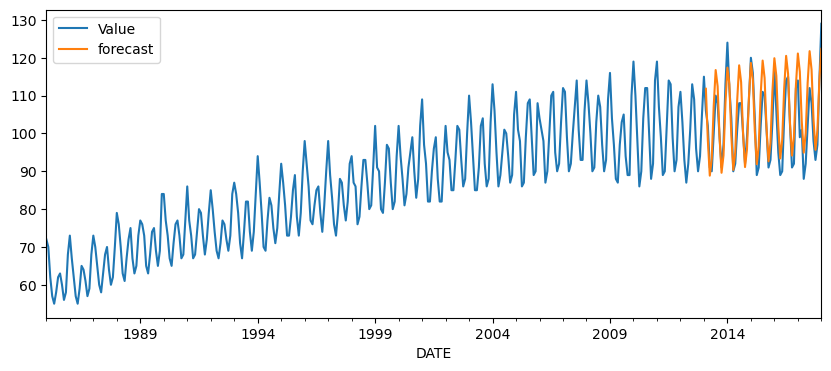

In [128]:
df.plot(figsize=(10,4))

In [129]:
import numpy as np

# Model Evaluation (RMSE)
from sklearn.metrics import mean_squared_error, mean_absolute_error
rmse = np.sqrt(mean_squared_error(test, pred))
mae = np.sqrt(mean_absolute_error(test, pred))

print(f'Root Mean Squared Error: {rmse}\nMean Absolute Error: {mae}')

Root Mean Squared Error: 5.864569848527431
Mean Absolute Error: 2.1838446755116196


In [ ]:
# We can see from ARIMA that it has a good pattern, although it do not follow the oscilations
# Maybe adding seasonality (SARIMA) can help us getting even a better performance

# SARIMA Model

In [130]:
import pandas as pd

df = pd.read_csv(r'C:\Users\Acer\DataSets\product_demand.csv')

In [131]:
df['Value'] = df['Value'].astype(int)
df['DATE'] = pd.to_datetime(df['DATE'])
df.set_index('DATE', inplace=True)

In [132]:
# Train/Test Split
train = df[:int(len(df)*0.85)]
test = df[int(len(df)*0.85):]

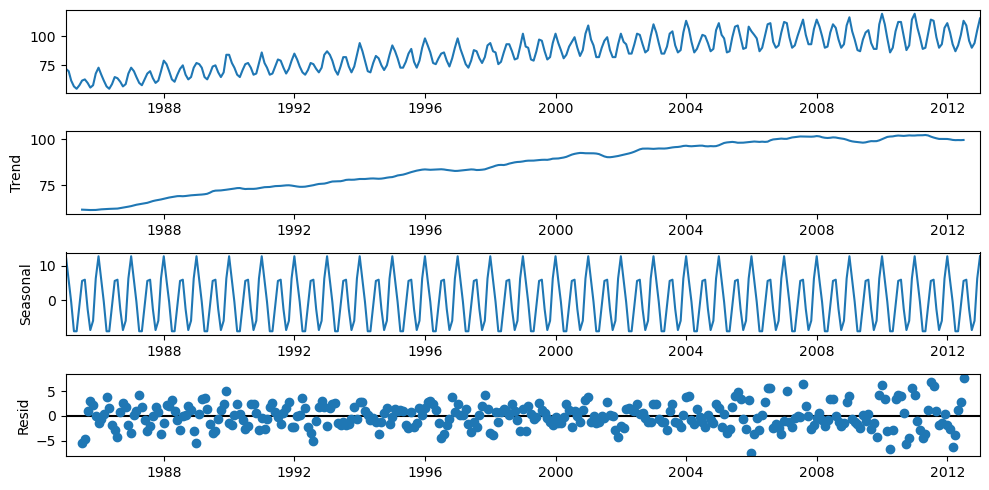

In [133]:
# Import
from statsmodels.tsa.seasonal import seasonal_decompose
# Decompose data
decomp_results = seasonal_decompose(train, period=12)

# Plot decomposed data
plt.rcParams["figure.figsize"] = (10,5)
decomp_results.plot()
plt.show()

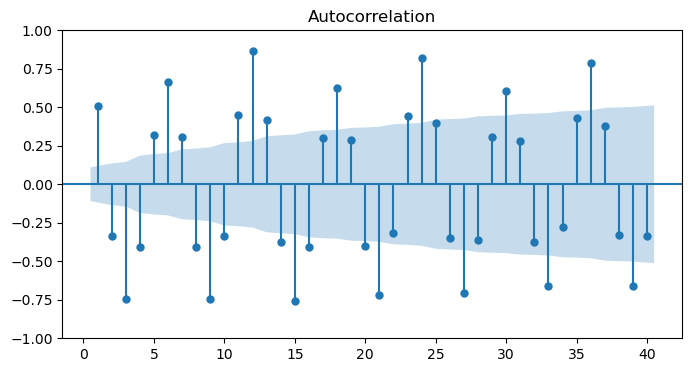

In [134]:
# It's visible that there's a seasonal component between every 12 months with a low and a high peak.
# We could have differenced the train data, because it has trend and thus is not stationarity from ADFuller test.
# But, since we are only interested in finding the periods of the time series, it will be clearer if we just subtract the rolling mean in the ACF plot.
# Subtracting the rolling mean in order to better understand the seasonality


# Subtract long rolling average over 5 steps
demand = train - train.rolling(20).mean()
# Drop NaN values
demand = demand.dropna()

# Identifying seasonal data using ACF

# Create figure
fig, ax = plt.subplots(1,1, figsize=(8,4))
# Plot ACF
plot_acf(demand, ax=ax, lags=40, zero=False)
plt.show()

In [ ]:
# We can see that the ACF plot show a strong pattern every 12 months. Thus, we have S=12

In [100]:
train

,Value
DATE,
1985-01-01,72
1985-02-01,70
1985-03-01,62
1985-04-01,57
1985-05-01,55
...,...
2012-09-01,96
2012-10-01,90
2012-11-01,94


In [ ]:
# To find P and Q seasonal orders, we can use the ACF and PACF plots, differencing time series at multiple seasonal steps
# We can set the lag parameters in ACF and PACF plot following the seasonality pattern (every 12 months)
# After doing that, we can use the same rules from ACF and PACF plot used on the first part of ARIMA

In [ ]:
# IMPORTANT
PACF -> AutoRegressive (P)
ACF -> Moving Average (Q)

C:\Users\Acer\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


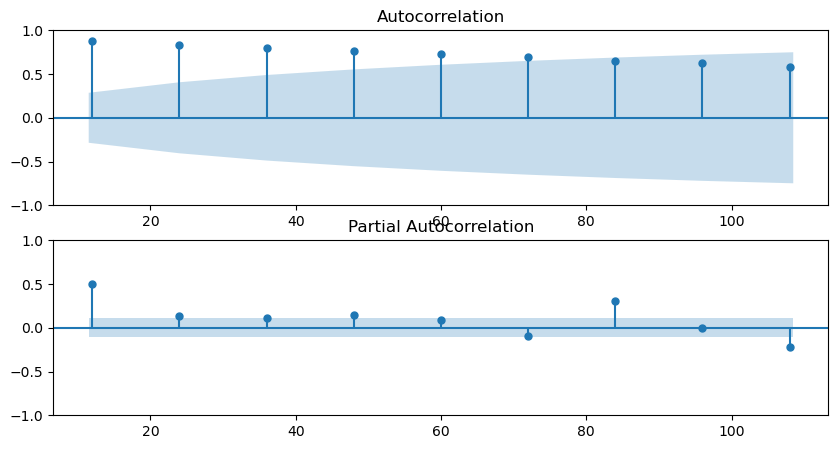

In [135]:
# Since we know train is not stationary, we will plot it on ACF and PACF one order differenced
# Plotting seasonal ACF and PACF to find seasonal parameters (P and Q)

# Create figure
fig, (ax1, ax2) = plt.subplots(2,1)

# Plot seasonal ACF
plot_acf(train.diff().dropna(), lags=[12, 24, 36, 48, 60, 72, 84, 96, 108], ax=ax1)

# Plot seasonal PACF
plot_pacf(train.diff().dropna(), lags=[12, 24, 36, 48, 60, 72, 84, 96, 108], ax=ax2)
plt.show()

In [ ]:
# From the ACF plot, we can see that ACF is trending down
# From the PACF plot, we can see a peak on lag 1
# The ACF and PACF plots follow a certain pattern, and suggestes that we will have P=1

In [ ]:
# But, before applying SARIMA, let's also use AIC and BIC to see what are the best orders for SARIMA

In [104]:
import pmdarima as pm

results = pm.auto_arima(train, # data
                        seasonal=True, # is the time series seasonal
                        m=12, # the seasonal period
                        start_D=0, # seasonal difference order
                        start_P=1, # initial guess for P
                        start_Q=1,
                        max_D = 2,# initial guess for Q
                        max_P=4, # max value of P to test
                        max_Q=4, # max value of Q to test
                        information_criterion='aic', # used to select best model
                        trace=True, # print results whilst training
                        error_action='ignore', # ignore orders that don't work
                        stepwise=True,
                       )

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=inf, Time=1.49 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=2300.619, Time=0.04 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=inf, Time=0.24 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=2009.079, Time=0.23 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=2298.720, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=2188.338, Time=0.08 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=1620.735, Time=0.92 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=1701.027, Time=0.27 sec
 ARIMA(0,1,1)(2,0,1)[12] intercept   : AIC=inf, Time=1.40 sec
 ARIMA(0,1,1)(1,0,2)[12] intercept   : AIC=1604.126, Time=2.17 sec
 ARIMA(0,1,1)(0,0,2)[12] intercept   : AIC=1933.080, Time=0.59 sec
 ARIMA(0,1,1)(2,0,2)[12] intercept   : AIC=inf, Time=2.73 sec
 ARIMA(0,1,1)(1,0,3)[12] intercept   : AIC=1592.539, Time=5.62 sec
 ARIMA(0,1,1)(0,0,3)[12] intercept   : AIC=1877.288, Time=1.72 sec
 ARIMA(0,1,1)(2,0,3)[12] intercept   : 

In [ ]:
# Looks like the best model for SARIMA is (1,1,2)(1,0,4)[12]

C:\Users\Acer\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Acer\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Acer\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Acer\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


                                           SARIMAX Results                                           
Dep. Variable:                                         Value   No. Observations:                  337
Model:             SARIMAX(1, 1, 2)x(1, 0, [1, 2, 3, 4], 12)   Log Likelihood                -758.769
Date:                                       Sun, 01 Oct 2023   AIC                           1535.537
Time:                                               17:03:43   BIC                           1569.891
Sample:                                           01-01-1985   HQIC                          1549.232
                                                - 01-01-2013                                         
Covariance Type:                                         opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2908     

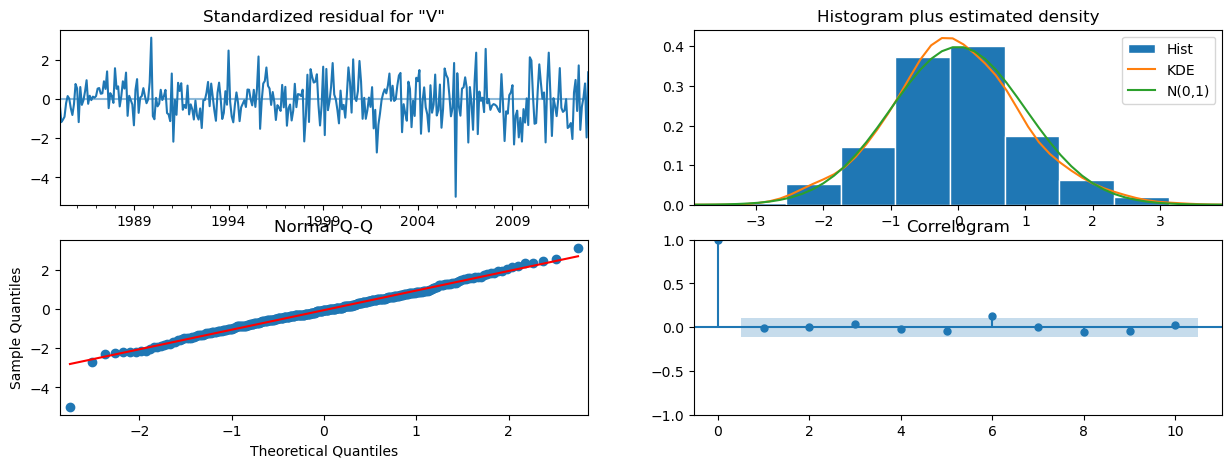

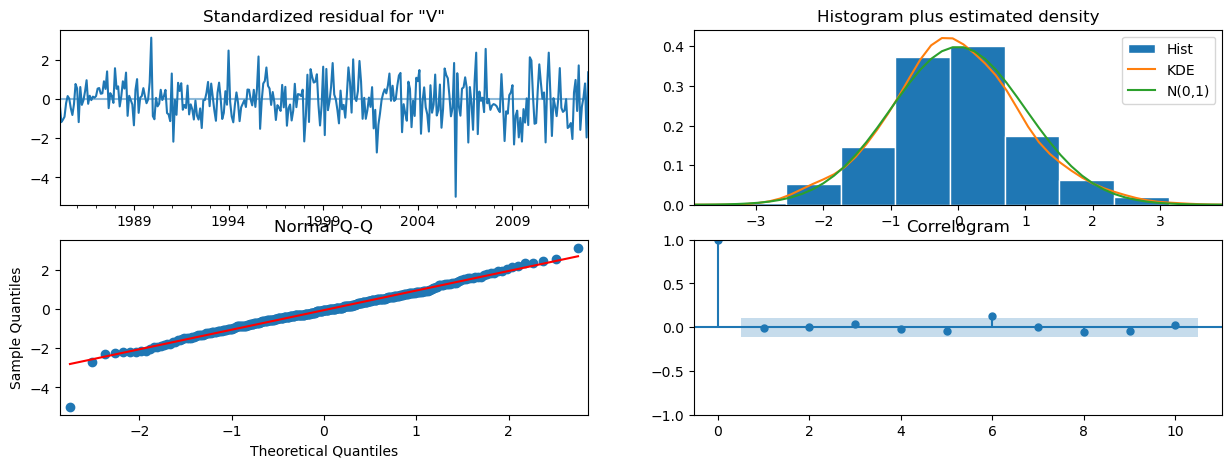

In [136]:
# Lets now fit the SARIMA model with (1,1,2)(1,0,4,12)
# Fitting a SARIMA model
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Instantiate model
S = 12
D = 0
d = 1
P = 1
Q = 4
p = 1
q = 2
model = SARIMAX(train, order=(p,d,q), seasonal_order=(P,D,Q,S))

# Fit model
results = model.fit()
plt.show()

# Print summary
print(results.summary())
results.plot_diagnostics(figsize=(15,5))

In [137]:
pred = results.predict(start=len(train), end=len(df)-1)

In [138]:
df['forecast'] = [None]*len(train) + list(pred)

<AxesSubplot:xlabel='DATE'>

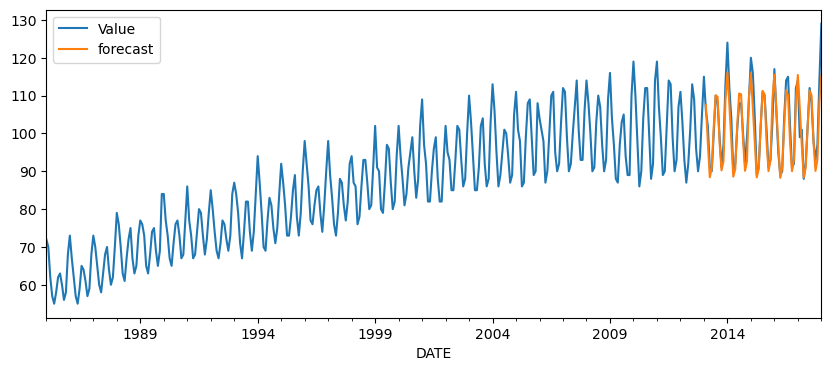

In [140]:
df.plot(figsize=(10,4))

In [141]:
import numpy as np

# Model Evaluation (RMSE)
from sklearn.metrics import mean_squared_error, mean_absolute_error
rmse = np.sqrt(mean_squared_error(test, pred))
mae = np.sqrt(mean_absolute_error(test, pred))

print(f'Root Mean Squared Error: {rmse}\nMean Absolute Error: {mae}')

Root Mean Squared Error: 3.7385099315909764
Mean Absolute Error: 1.6348056299597553


# SARIMA FOR WHOLE DATASET

In [142]:
import pandas as pd

import pandas as pd

df = pd.read_csv(r'C:\Users\Acer\DataSets\product_demand.csv')

df['Value'] = df['Value'].astype(int)
df['DATE'] = pd.to_datetime(df['DATE'])
df.set_index('DATE', inplace=True)

C:\Users\Acer\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Acer\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Acer\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                                           SARIMAX Results                                           
Dep. Variable:                                         Value   No. Observations:                  397
Model:             SARIMAX(1, 1, 2)x(1, 0, [1, 2, 3, 4], 12)   Log Likelihood                -921.662
Date:                                       Sun, 01 Oct 2023   AIC                           1861.323
Time:                                               17:04:19   BIC                           1897.156
Sample:                                           01-01-1985   HQIC                          1875.519
                                                - 01-01-2018                                         
Covariance Type:                                         opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3716     

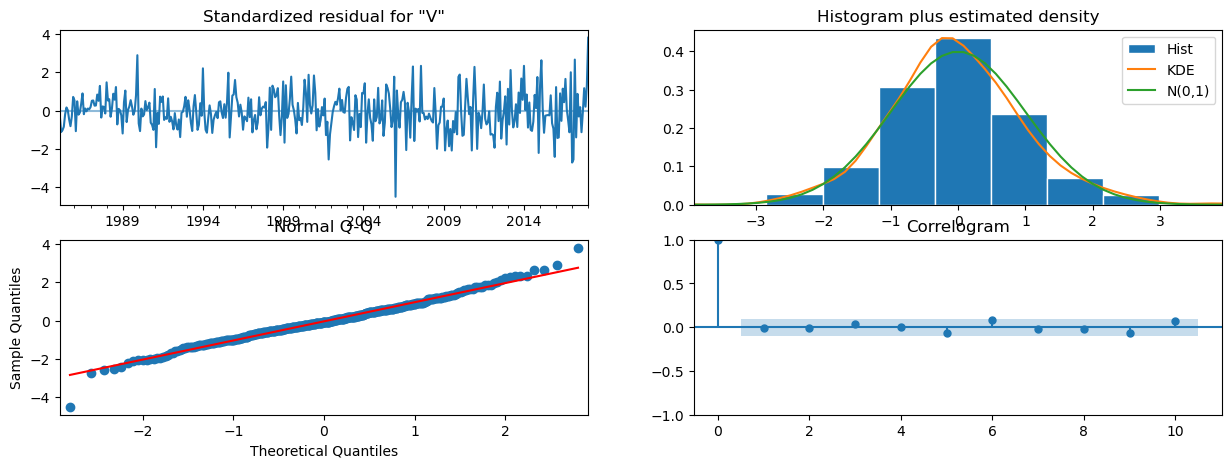

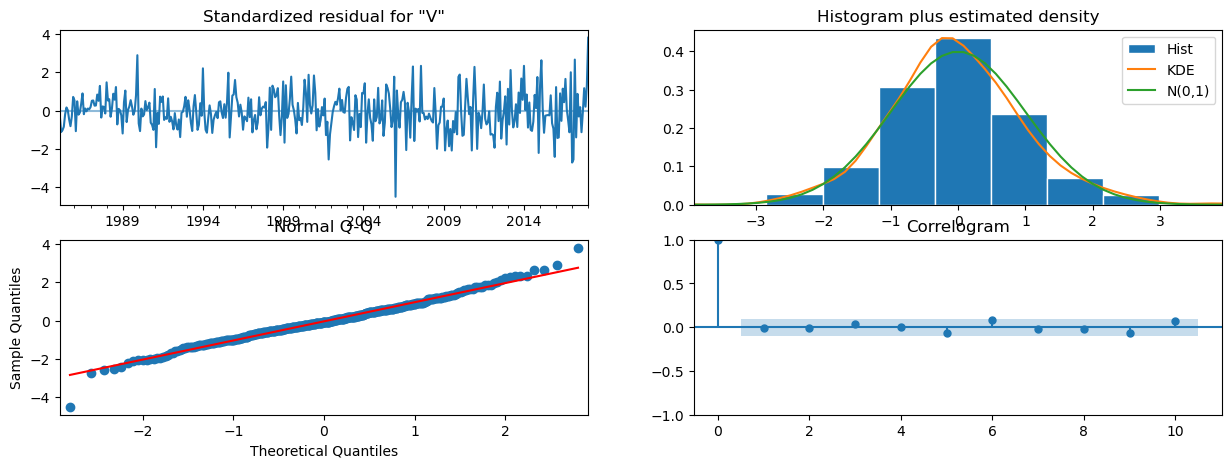

In [143]:
# Lets now fit the SARIMA model
# Fitting a SARIMA model
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Instantiate model
S = 12
D = 0
d = 1
P = 1
Q = 4
p = 1
q = 2
model = SARIMAX(df, order=(p,d,q), seasonal_order=(P,D,Q,S))

# Fit model
results = model.fit()
plt.show()

# Print summary
print(results.summary())
results.plot_diagnostics(figsize=(15,5))

In [144]:
from pandas.tseries.offsets import DateOffset
future_dates = [df.index[-1] + DateOffset(months=x) for x in range(0,60)]

In [146]:
future_dates_df = pd.DataFrame(index=future_dates[1:], columns = df.columns)

In [147]:
future_df = pd.concat([df, future_dates_df])

In [148]:
future_df['Forecast'] = results.predict(start = len(df), end = len(df)+60, dynamic=True)

<AxesSubplot:>

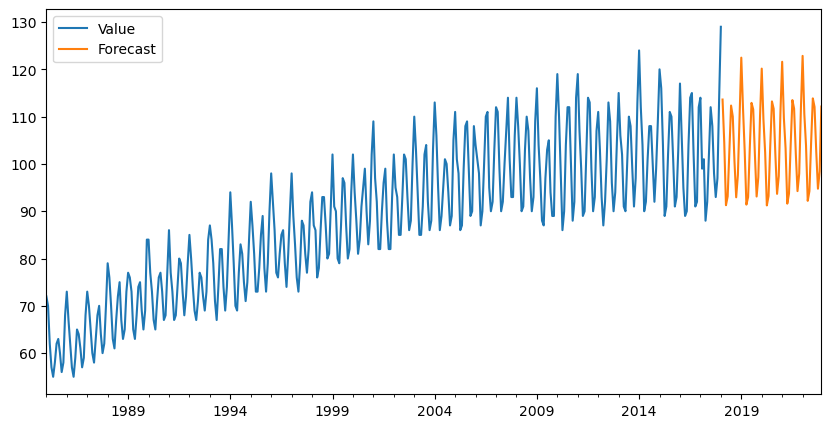

In [149]:
future_df[['Value', 'Forecast']].plot(figsize=(10,5))

In [ ]:
# Possibilities to tune the model using exogenous parameters (SARIMAX)